# Česká republika

Vypracovali Tomáš Novotný, Martin Beneš a Petr Fiedler.

## 0. Příprava dat

In [1]:
library(eurostat)
library(dplyr)
library(ggplot2)
library(e1071)
library(DescTools)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
data <- get_eurostat("demo_r_pjanaggr3")
sample_n(data, 6)

Table demo_r_pjanaggr3 cached at /tmp/RtmpLMSw7l/eurostat/demo_r_pjanaggr3_date_code_FF.rds



unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,F,TOTAL,DE242,2012-01-01,37168
NR,F,UNK,RO114,2013-01-01,0
NR,T,UNK,UK,2012-01-01,0
NR,M,Y_LT15,UKK1,2010-01-01,204986
NR,T,Y_GE65,FRI31,2014-01-01,80328
NR,T,Y_GE65,BE252,2016-01-01,10328


In [3]:
nuts <- c("CZ010", "CZ020", "CZ031", "CZ032", "CZ041", "CZ042", "CZ051", "CZ052", "CZ053", "CZ063", "CZ064", "CZ071", "CZ072", "CZ080")
data <- data[data$geo %in% nuts,]
sample_n(data, 6)

unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,M,UNK,CZ020,2022-01-01,0
NR,F,Y_LT15,CZ010,2017-01-01,94998
NR,F,Y15-64,CZ051,2001-01-01,150608
NR,F,Y_LT15,CZ064,2012-01-01,81833
NR,T,Y_GE65,CZ063,2010-01-01,80087
NR,T,Y15-64,CZ010,2005-01-01,832710


In [4]:
print("Unique values in 'data':")
print(unique(data$unit))
print("Unique values in 'sex':")
print(unique(data$sex))
print("Unique values in 'age':")
print(unique(data$age))
print("Unique values in 'time':")
print(unique(data$time))

[1] "Unique values in 'data':"
[1] "NR"
[1] "Unique values in 'sex':"
[1] "F" "M" "T"
[1] "Unique values in 'age':"
[1] "TOTAL"  "UNK"    "Y15-64" "Y_GE65" "Y_LT15"
[1] "Unique values in 'time':"
 [1] "2022-01-01" "2021-01-01" "2020-01-01" "2019-01-01" "2018-01-01"
 [6] "2017-01-01" "2016-01-01" "2015-01-01" "2014-01-01" "2013-01-01"
[11] "2012-01-01" "2011-01-01" "2010-01-01" "2009-01-01" "2008-01-01"
[16] "2007-01-01" "2006-01-01" "2005-01-01" "2004-01-01" "2003-01-01"
[21] "2002-01-01" "2001-01-01" "2000-01-01" "1993-01-01" "1992-01-01"


In [5]:
data$unit <- NULL
data$geo <- as.factor(data$geo)

data <- data[data$age == "TOTAL",]
data$age <- NULL

data <- data[data$time == '2021-01-01',]
data$time <- NULL

data <- data[data$sex %in% c("M", "F"),]
data$sex <- as.factor(data$sex)

data <- label_eurostat(data)

sample_n(data, 10)

sex,geo,values
<fct>,<fct>,<dbl>
Females,Královéhradecký kraj,279123
Females,Plzenský kraj,297223
Females,Olomoucký kraj,321804
Females,Jihocecký kraj,325503
Males,Ústecký kraj,405277
Males,Královéhradecký kraj,271680
Females,Pardubický kraj,263067
Males,Kraj Vysocina,253153
Females,Karlovarský kraj,148298


In [6]:
data$region <- data$geo
data$geo <- NULL

data$population <- data$values
data$values <- NULL

data <- data[, c(2, 1, 3)]

sample_n(data, 10)

region,sex,population
<fct>,<fct>,<dbl>
Liberecký kraj,Males,217847
Pardubický kraj,Males,259789
Královéhradecký kraj,Females,279123
Jihomoravský kraj,Females,607865
Jihocecký kraj,Females,325503
Ústecký kraj,Females,411727
Hlavní mesto Praha,Males,653654
Moravskoslezský kraj,Males,584073
Kraj Vysocina,Females,255699


## 1. Základní statistická šetření

### Popis dat

Data obsahují informace o počtech obyvatel v jednotlivých krajích České republiky vázaných k roku 2021, přičemž rozlišujeme muže a ženy.

Nejprve se podíváme na data jako celek. Budeme tedy zkoumat jednotlivé záznamy o populaci napříč kraji a pohlavími.

### Základní statistické míry

Vypíšeme nejdůležitější statistické míry:

In [7]:
summary(data)

                region        sex       population    
 Hlavní mesto Praha: 2   Females:14   Min.   :145013  
 Stredoceský kraj  : 2   Males  :14   1st Qu.:262248  
 Jihocecký kraj    : 2                Median :302970  
 Plzenský kraj     : 2                Mean   :382206  
 Karlovarský kraj  : 2                3rd Qu.:584920  
 Ústecký kraj      : 2                Max.   :706011  
 (Other)           :16                                

- Jak bylo očekáváno, máme 14 krajů a ke každému kraji máme 2 záznamy - jeden pro muže a druhý pro ženy.
- Již z počátečních statistik lze pozorovat, že 25 % hodnot počtu obyvatel se nachází v relativně malém intervalu ~260 000 - ~300 000 obyvatel.
- Je překvapivé, že počty obyvatel mužů nebo žen v rámci krajů se pohybují mezi ~150 000 až do ~700 000.
- Medián je nižší než průměr o ~80 000, můžeme tedy očekávat odlehlé hodnoty, které nám "odsouvají" průměr.

Další statistiky:

In [8]:
print(paste("výběrová směrodatná odchylka:", round(sd(data$population), 2)))
print(paste("rozpětí:", max(data$population) - min(data$population)))
print(paste("mezikvartilové rozpětí:", IQR(data$population)))
print(paste("výběrová šikmost:", round(skewness(data$population), 2)))
print(paste("výběrová špičatost:", round(kurtosis(data$population), 2)))

[1] "výběrová směrodatná odchylka: 177066.74"
[1] "rozpětí: 560998"
[1] "mezikvartilové rozpětí: 322672.75"
[1] "výběrová šikmost: 0.66"
[1] "výběrová špičatost: -1.13"


- Směrodatná odchylka je ~175 000, data jsou tedy očekávatelně rozptýlena kolem střední hodnoty.

- Mezikvartilové rozpětí je přibližně poloviční oproti celkovému rozpětí. To znamená, že prostřední polovina dat má přibližně poloviční rozpětí oproti všem datům.

- Pozorujeme poměrně výraznou šikmost doprava, to znamená, že nižší hodnoty dat jsou četnější než vyšší.

- Výběrová špičatost je záporná, data jsou tedy "naploštělá".

Data dále prozkoumáme také pomocí grafů, což nám umožní jim lépe porozumět.

### Histogram

Abychom lépe porozuměli rozložení hodnot, vykreslíme histogram.

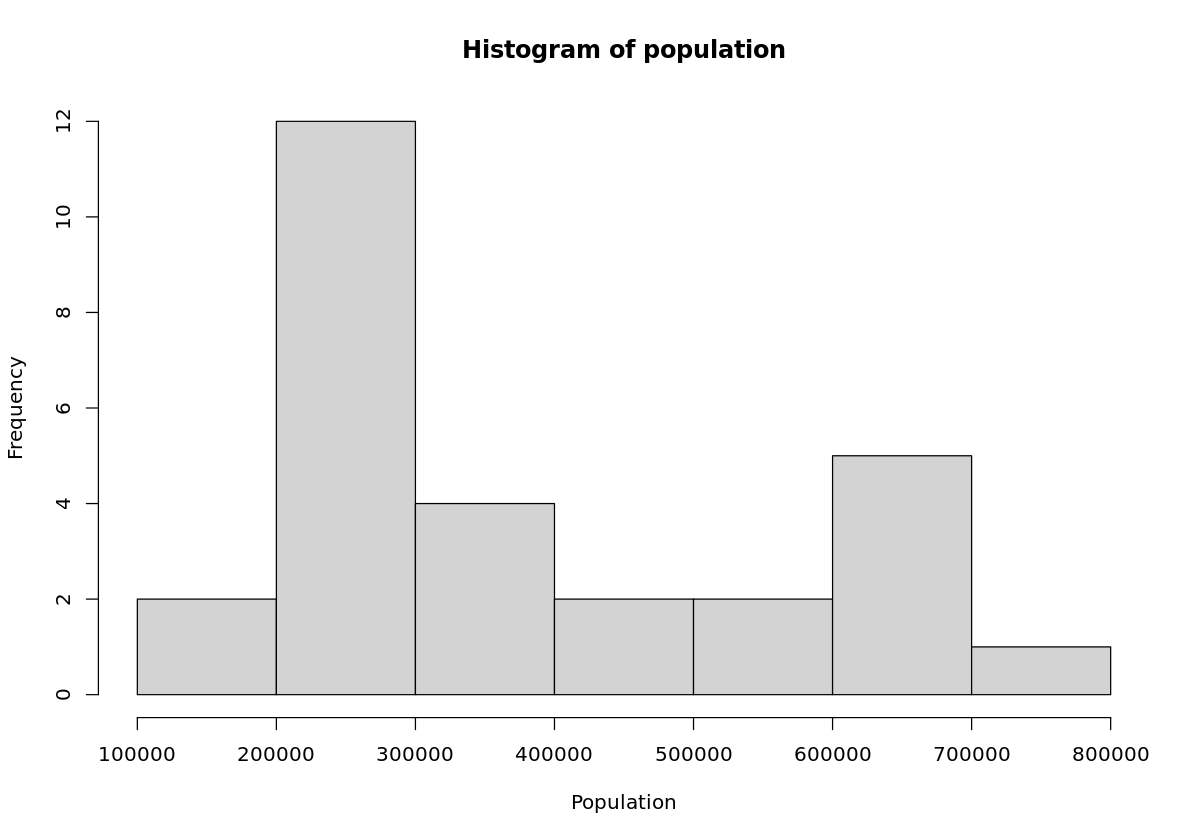

In [9]:
options(repr.plot.width=10, repr.plot.height=7, scipen=5)
hist(data$population, main="Histogram of population", xlab="Population", ylab="Frequency")

Opět se potvrzuje naše pozorování, že hodnoty jsou nahuštěny mezi 200 000 a 300 000. Dále pozorujeme "peak" mezi 600 000 a 700 000. Očekáváme tedy 2 mody: nejvyšší modus ~250 000 a druhý ~650 000.

### Boxplot

Nyní vykreslíme krabicový graf, který nám poskytne další náhled na data.

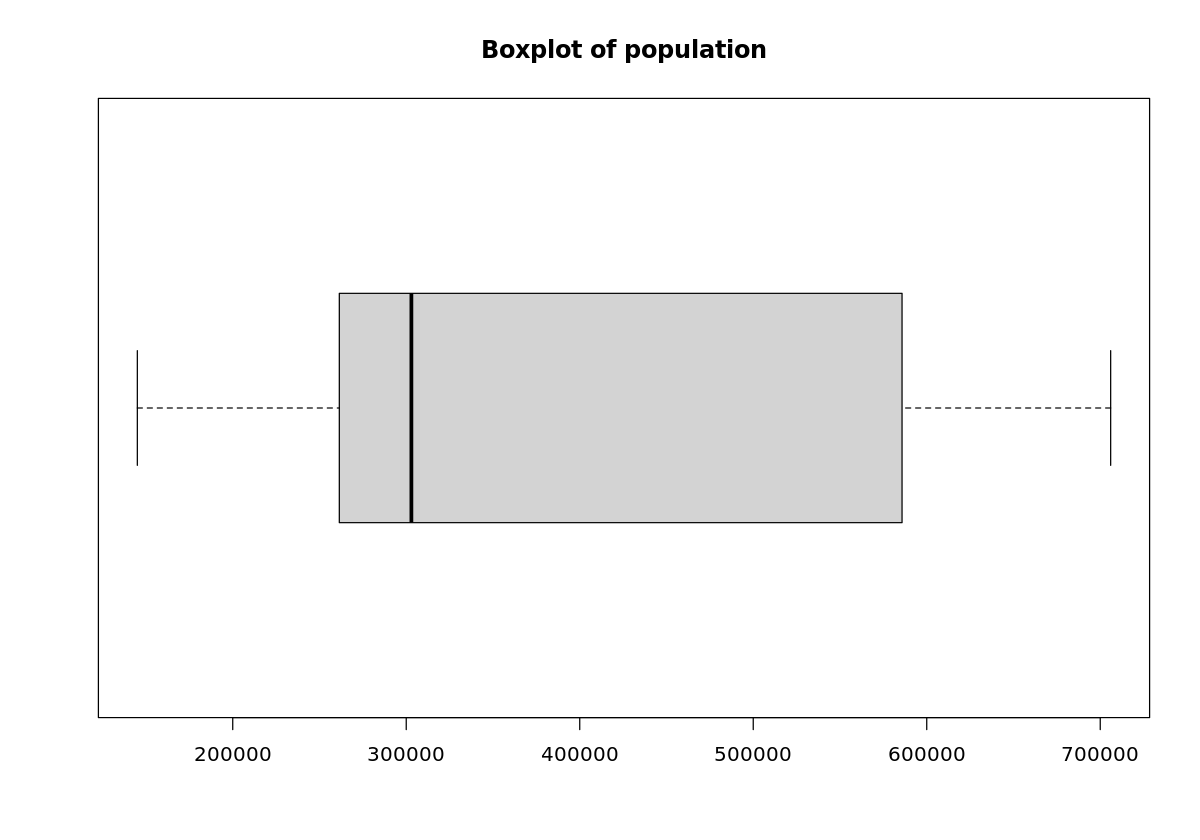

In [10]:
boxplot(data$population, main="Boxplot of population", horizontal=TRUE)

Vidíme, že medián je velmi blízko prvnímu kvartilu. Nepozorujeme odlehlé hodnoty.

### Porovnání mezi pohlavími

Nyní se podíváme, jestli (a případně jaký) je rozdíl v datech mezi pohlavími.

Nejprve vykreslíme histogramy zvlášť pro obě pohlaví.

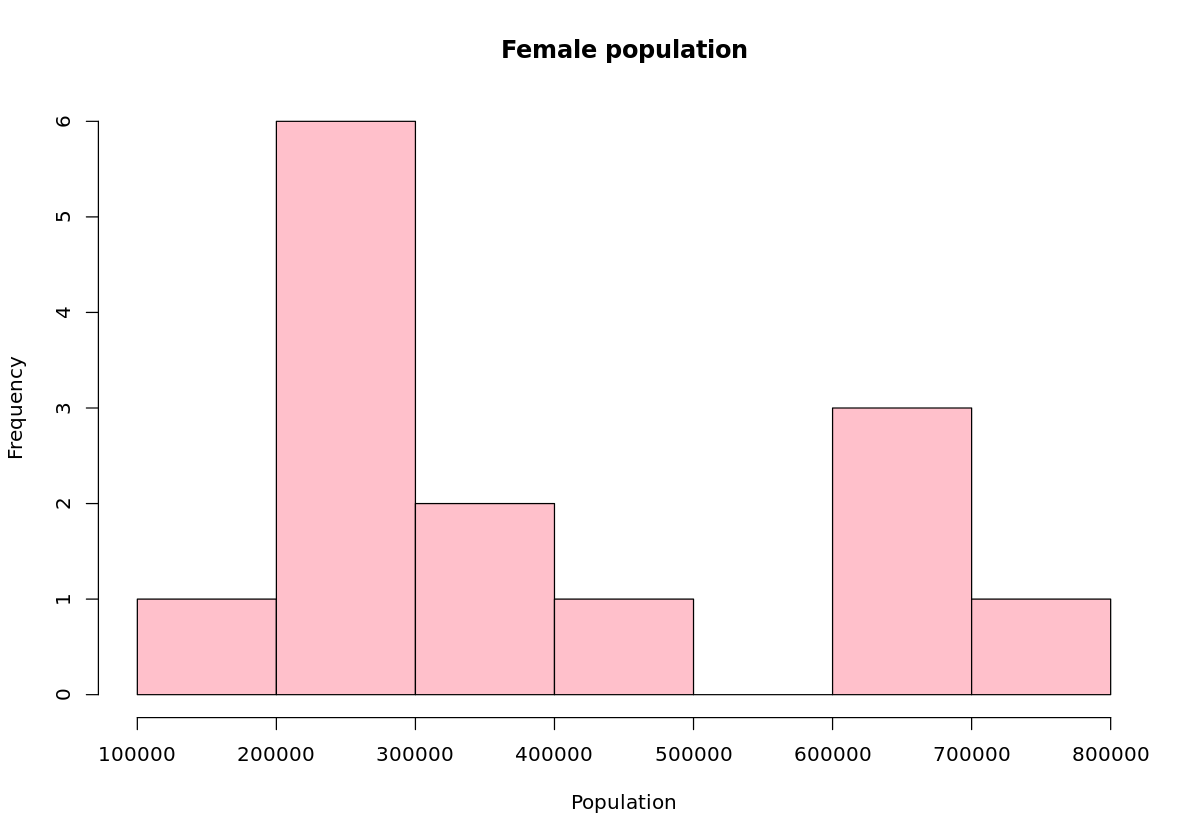

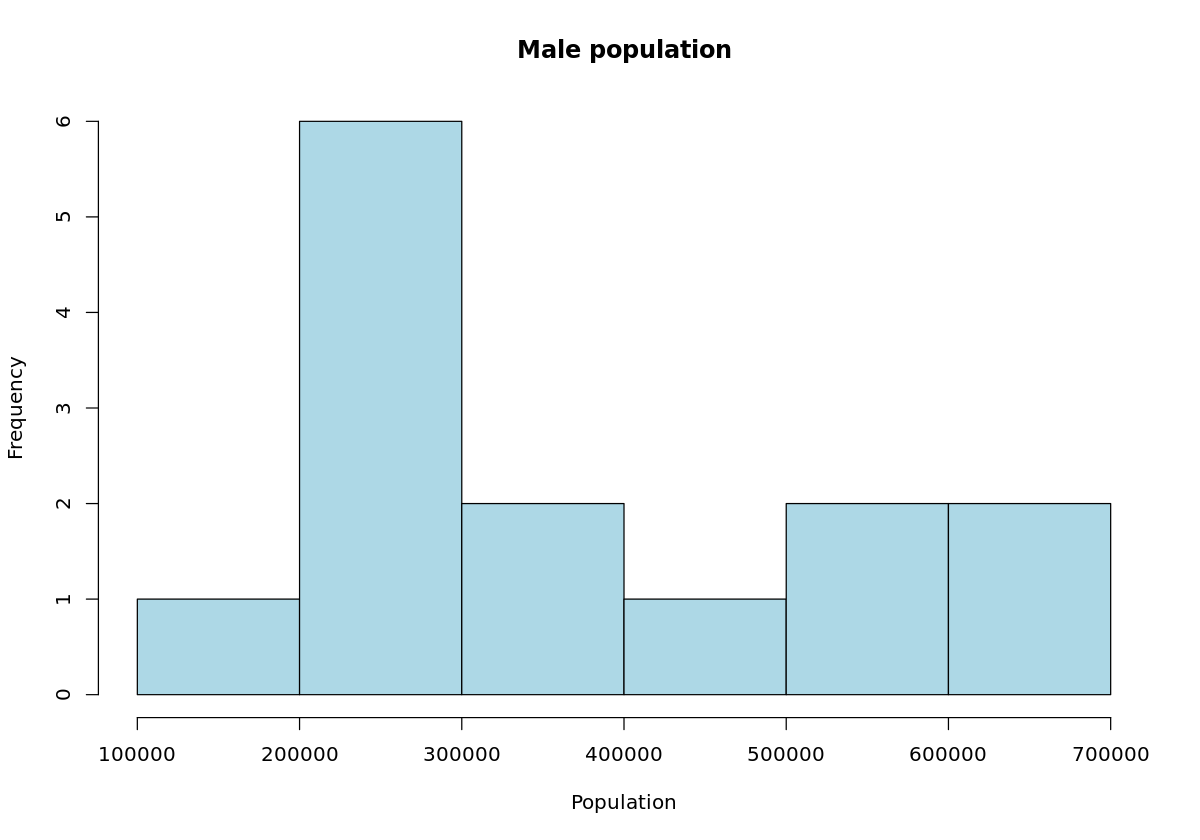

In [11]:
hist(subset(data, sex == "Females")$population, main="Female population", xlab="Population", ylab="Frequency", col="pink")
hist(subset(data, sex == "Males")$population, main="Male population", xlab="Population", ylab="Frequency", col="lightblue")

Vidíme, že jsou histogramy podobné. U datových bodů s vyšší populací lze pozorovat drobné rozdíly v četnosti.

Podíváme se ještě na violin ploty a boxploty.

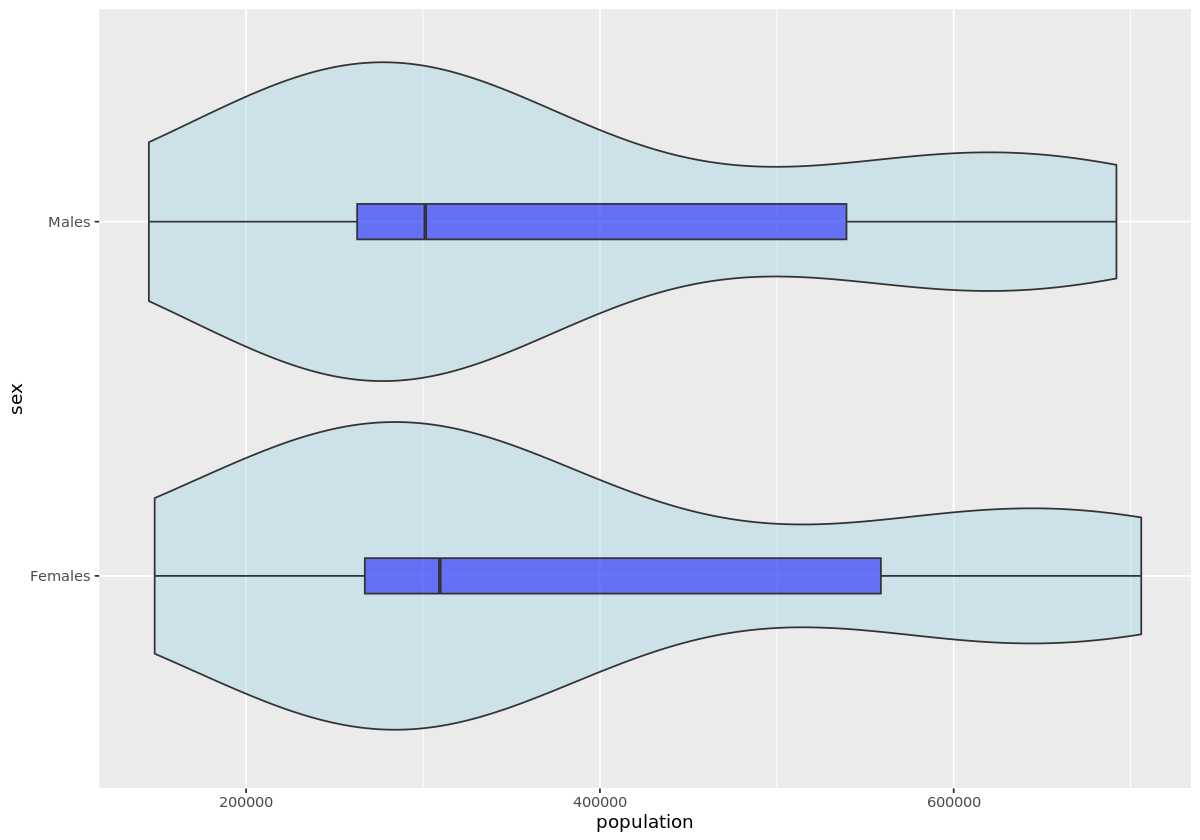

In [12]:
ggplot(data, aes(x=population, y=sex)) +
    geom_violin(fill="lightblue", alpha=0.5) +
    geom_boxplot(width=0.1, fill="blue", alpha=0.5)

Okometricky se zdají hodnoty obou skupin velice podobně rozložené. Nepozorujeme tedy značný populační rozdíl mezi muži a ženami. To později také ověříme testem.

### Vizualizace populace jednotlivých krajů

Vizualizujeme počet obyvatel (mužů i žen dohromady) v jednotlivých krajích.

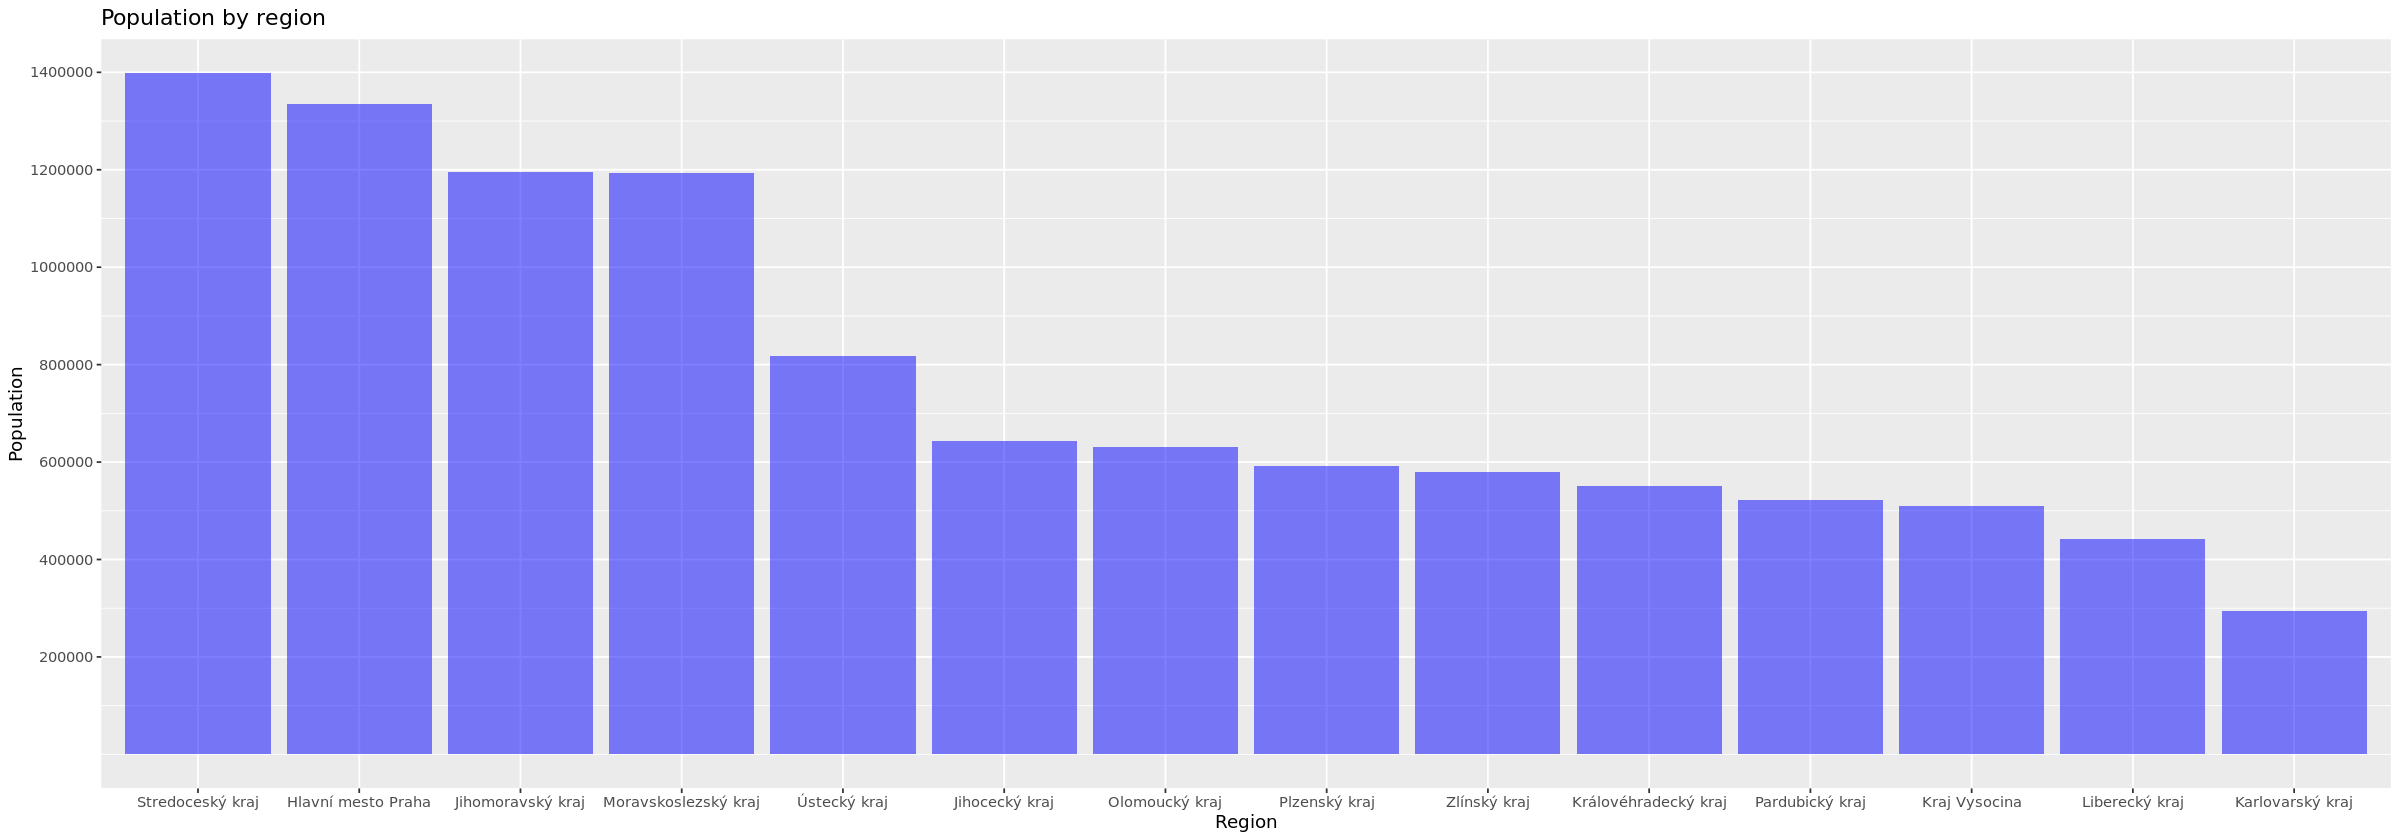

In [13]:
options(repr.plot.width=20, repr.plot.height=7)
ggplot(data, aes(x=reorder(region, -population), y=population)) +
    geom_bar(stat="identity", fill="blue", alpha=.5) +
    scale_y_continuous(breaks=pretty(2*data$population, 5)) +
    labs(x="Region", y="Population", title="Population by region")

Vidíme, že počty obyvatel v jednotlivých krajích se značně liší. Rozdíl mezi Středočeským a Karlovarským krajem je více než 100 000 obyvatel.

## 2. Hypotézy

### 2.1 Shodnost distribucí počtu obyvatel v rámci krajů u mužů a žen

Když jsme porovnávali muže a ženy při průzkumu dat, dokázali jsme shodu posoudit pouze vizuálně. Naše pozorování tedy nyní podpoříme testem.

Označíme $F_M$ distribuční funkci spojitého rozdělení, ze kterého pochází výběr mužů a $F_F$ distribuční funkci spojitého rozdělení, ze kterého pochází výběr žen.

Testujeme hypotézy:

- $H_0$: $F_M = F_F$
- $H_A$: $F_M \ne F_F$

K testu shody distribucí použijeme Mannův-Whitneyúv test. Tento test je sice poněkud citlivý na posun a odchylky ve tvaru, avšak z vizualizací se tyto rozdíly nezdály příliš patrné.

In [14]:
wilcox.test(population ~ sex, data = data)


	Wilcoxon rank sum exact test

data:  population by sex
W = 108, p-value = 0.6673
alternative hypothesis: true location shift is not equal to 0


Vyšla p-hodnota vyšší než 0.05. Nulovou hypotézu na standardní hladině významnosti nezamítáme.

Můžeme se tedy domnívat, že populace napříč kraji se u žen a mužů příliš neliší.

### 2.2 Rovnost mediánu počtu obyvatel NUTS 3 regionů v ČR vůči EU

Při průzkumu dat jsme zjistili, že data jsou nahuštěná mezi 200 000 a 300 000.
Nabízí se otázka, zda je podobný trend pozorovatelný i v rámci celé EU.

To otestujeme pomocí _jednovýběrového Wilcoxonova znaménkového testu_.
Budeme testovat, zda je medián českých dat shodný s mediánem pro EU.

>Poznámka: Nejprve jsme se snažili otestovat shodu střední hodnoty, ale všechny námi známé dvouvýběrové testy střední hodnoty předpokládaly normalitu, kterou jsme na základě Shapirova-Wilkova testu zamítli.

Začněme načtením všech NUTS 3 regionů v EU.

In [15]:
eu.data <- get_eurostat("demo_r_pjanaggr3")
# NUTS 3 regiony maji 5 znaku:
#   prvni    2 cislice slouzi k identifikaci statu,
#   posledni 3 cislice k identifikaci NUTS 3 regionu
eu.data <- filter(eu.data, nchar(geo) == 5)
eu.data <- eu.data[eu.data$age == "TOTAL",]
eu.data <- eu.data[eu.data$time == '2021-01-01',]
eu.data <- eu.data[eu.data$sex == "T",] # TOTAL

head(eu.data)

Reading cache file /tmp/RtmpLMSw7l/eurostat/demo_r_pjanaggr3_date_code_FF.rds

Table  demo_r_pjanaggr3  read from cache file:  /tmp/RtmpLMSw7l/eurostat/demo_r_pjanaggr3_date_code_FF.rds



unit,sex,age,geo,time,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
NR,T,TOTAL,AL011,2021-01-01,113683
NR,T,TOTAL,AL012,2021-01-01,292029
NR,T,TOTAL,AL013,2021-01-01,74388
NR,T,TOTAL,AL014,2021-01-01,120678
NR,T,TOTAL,AL015,2021-01-01,197177
NR,T,TOTAL,AL021,2021-01-01,266245


Z dat vypočtěme medián.

In [16]:
eu.median.population <- median(eu.data$values)
round(eu.median.population)

[1] 259351

Nyní nám zbývá dostat z našich dat celkový počet obyvatel v regionu (součet mužů a žen).

In [17]:
# add males and females to get total population in each region
population.by.region <- aggregate(population ~ region, data = data, FUN = sum)
population.by.region

region,population
<fct>,<dbl>
Hlavní mesto Praha,1335084
Stredoceský kraj,1397997
Jihocecký kraj,643551
Plzenský kraj,591041
Karlovarský kraj,293311
Ústecký kraj,817004
Liberecký kraj,442476
Královéhradecký kraj,550803
Pardubický kraj,522856


A konečně můžeme provést _jednovýběrový Wilcoxonův znaménkový test_:

Označme medián počtu obyvatel NUTS 3 regionu v ČR $\tilde{x}$ a $x_0$ medián počtu obyvatel NUTS 3 regionu v EU. Testujeme hypotézu
- $H_0$: $\tilde{x} = x_0$
- $H_A$: $\tilde{x} \ne x_0$

In [18]:
wilcox.test(population.by.region$population, mu = eu.median.population)


	Wilcoxon signed rank exact test

data:  population.by.region$population
V = 105, p-value = 0.0001221
alternative hypothesis: true location is not equal to 259351


_p-hodnota_ je menší než 0.05, na standardní hladině významnosti tedy **zamítáme** nulovou hypotézu ve prospěch alternativy.

### 2.3 Hypotéza zda má populace v regionech na Slovensku stejné rozdělení jako populace regionů v Česku

Česká republika se Slovenskou republikou mají dlouhou společnou historii a jsou si v mnoha demografických oblastech podobné. Proto by nás zajímalo, zda má populace regionů v Česku a na Slovensku stejné rozdělení.

*Poznámka*: Nejprve jsme se snažili otestovat shodu střední hodnoty, ale všechny námi známé dvouvýběrové testy střední hodnoty předpokládaly normalitu, kterou jsme na základě Shapirova-Wilkova testu zamítli.

* Data o populaci jednotlivých regionů Slovenska získáme obdobným způsobem jako pro Česko.

In [19]:
sr_data <- get_eurostat("demo_r_pjanaggr3")
sr_nuts <- c('SK010', 'SK021', 'SK022', 'SK023', 'SK031', 'SK032', 'SK041', 'SK042')
sr_data <- sr_data[sr_data$geo %in% sr_nuts,]
sr_data$unit <- NULL
sr_data$geo <- as.factor(sr_data$geo)

sr_data <- sr_data[sr_data$age == "TOTAL",]
sr_data$age <- NULL

sr_data <- sr_data[sr_data$time == '2021-01-01',]
sr_data$time <- NULL

sr_data <- sr_data[sr_data$sex == 'T',]
sr_data$sex <- NULL

sr_data <- label_eurostat(sr_data)

sr_data$region <- sr_data$geo
sr_data$geo <- NULL

sr_data$population <- sr_data$values
sr_data$values <- NULL

sr_data
population.by.region

Reading cache file /tmp/RtmpLMSw7l/eurostat/demo_r_pjanaggr3_date_code_FF.rds

Table  demo_r_pjanaggr3  read from cache file:  /tmp/RtmpLMSw7l/eurostat/demo_r_pjanaggr3_date_code_FF.rds



region,population
<fct>,<dbl>
Bratislavský kraj,677024
Trnavský kraj,565324
Trenciansky kraj,582567
Nitriansky kraj,671508
Zilinský kraj,691136
Banskobystrický kraj,643102
Presovský kraj,827028
Kosický kraj,802092


region,population
<fct>,<dbl>
Hlavní mesto Praha,1335084
Stredoceský kraj,1397997
Jihocecký kraj,643551
Plzenský kraj,591041
Karlovarský kraj,293311
Ústecký kraj,817004
Liberecký kraj,442476
Královéhradecký kraj,550803
Pardubický kraj,522856


Při prvním vizuálním porovnání dat se zdá, že mohou mít výběry větší odchylku ve tvaru a rozptylu rozdělení, a proto pro __test shodnosti distribuce__ zvolíme `Kolmogorovovův-Smirnovův dvouvýběrový test`, který *není* oproti `Mannovu-Whitneyovu U testu` tolik citlivý na zmíněné vlastnosti rozdělení.

Označme $F$ distribuční funkci populace českých regionů a $G$ distribuční funkci populace slovenských regionů.

Testujeme hypotézu:

- $H_0$: $F=G$
- $H_A$: $F\ne G$ .

In [20]:
ks.test(population.by.region$population, sr_data$population)


	Two-sample Kolmogorov-Smirnov test

data:  population.by.region$population and sr_data$population
D = 0.35714, p-value = 0.4578
alternative hypothesis: two-sided


 - `p-hodnota` je `nad hranicí 0.05`, a proto nulovou hypotézu (shodnost distribucí populace regionů Česka a Slovenska) `nezamítáme`.

## Kontingenční tabulka

Z našich dat vytvoříme jednoduše kontingenční tabulku pomocí funkce `xtabs`.

Orientaci volíme takovou, že v řádcích máme regiony a ve sloupcích pohlaví.

In [21]:
c.table <- xtabs(formula=population ~ region + sex, data=data)
c.table

                      sex
region                 Females  Males
  Hlavní mesto Praha    681430 653654
  Stredoceský kraj      706011 691986
  Jihocecký kraj        325503 318048
  Plzenský kraj         297223 293818
  Karlovarský kraj      148298 145013
  Ústecký kraj          411727 405277
  Liberecký kraj        224629 217847
  Královéhradecký kraj  279123 271680
  Pardubický kraj       263067 259789
  Kraj Vysocina         255699 253153
  Jihomoravský kraj     607865 587462
  Olomoucký kraj        321804 308718
  Zlínský kraj          295534 284585
  Moravskoslezský kraj  608761 584073

Nyní zobrazíme kontingenční tabulku společně s marginálními součty.

In [22]:
addmargins(c.table)

,Females,Males,Sum
Hlavní mesto Praha,681430,653654,1335084
Stredoceský kraj,706011,691986,1397997
Jihocecký kraj,325503,318048,643551
Plzenský kraj,297223,293818,591041
Karlovarský kraj,148298,145013,293311
Ústecký kraj,411727,405277,817004
Liberecký kraj,224629,217847,442476
Královéhradecký kraj,279123,271680,550803
Pardubický kraj,263067,259789,522856
Kraj Vysocina,255699,253153,508852


Dále si zobrazíme kontingeční tabulku pravděpodobností a marginálních pravděpodobností.

In [23]:
addmargins(prop.table(c.table))

,Females,Males,Sum
Hlavní mesto Praha,0.06367447,0.06107902,0.12475349
Stredoceský kraj,0.06597138,0.06466085,0.13063223
Jihocecký kraj,0.03041579,0.02971918,0.06013497
Plzenský kraj,0.02777324,0.02745507,0.05522830
Karlovarský kraj,0.01385732,0.01355037,0.02740769
Ústecký kraj,0.03847277,0.03787007,0.07634284
Liberecký kraj,0.02098988,0.02035615,0.04134603
Královéhradecký kraj,0.02608193,0.02538644,0.05146837
Pardubický kraj,0.02458162,0.02427531,0.04885693
Kraj Vysocina,0.02389313,0.02365523,0.04754837


Následující mozaikový graf nám může odhalit nepoměry mužů a žen v krajích.

Na první pohled se ale počty žen a mužů v regionech `zdají` vyvážené. Tuto myšlenku v následujících testech rozvedeme a formalizujeme.

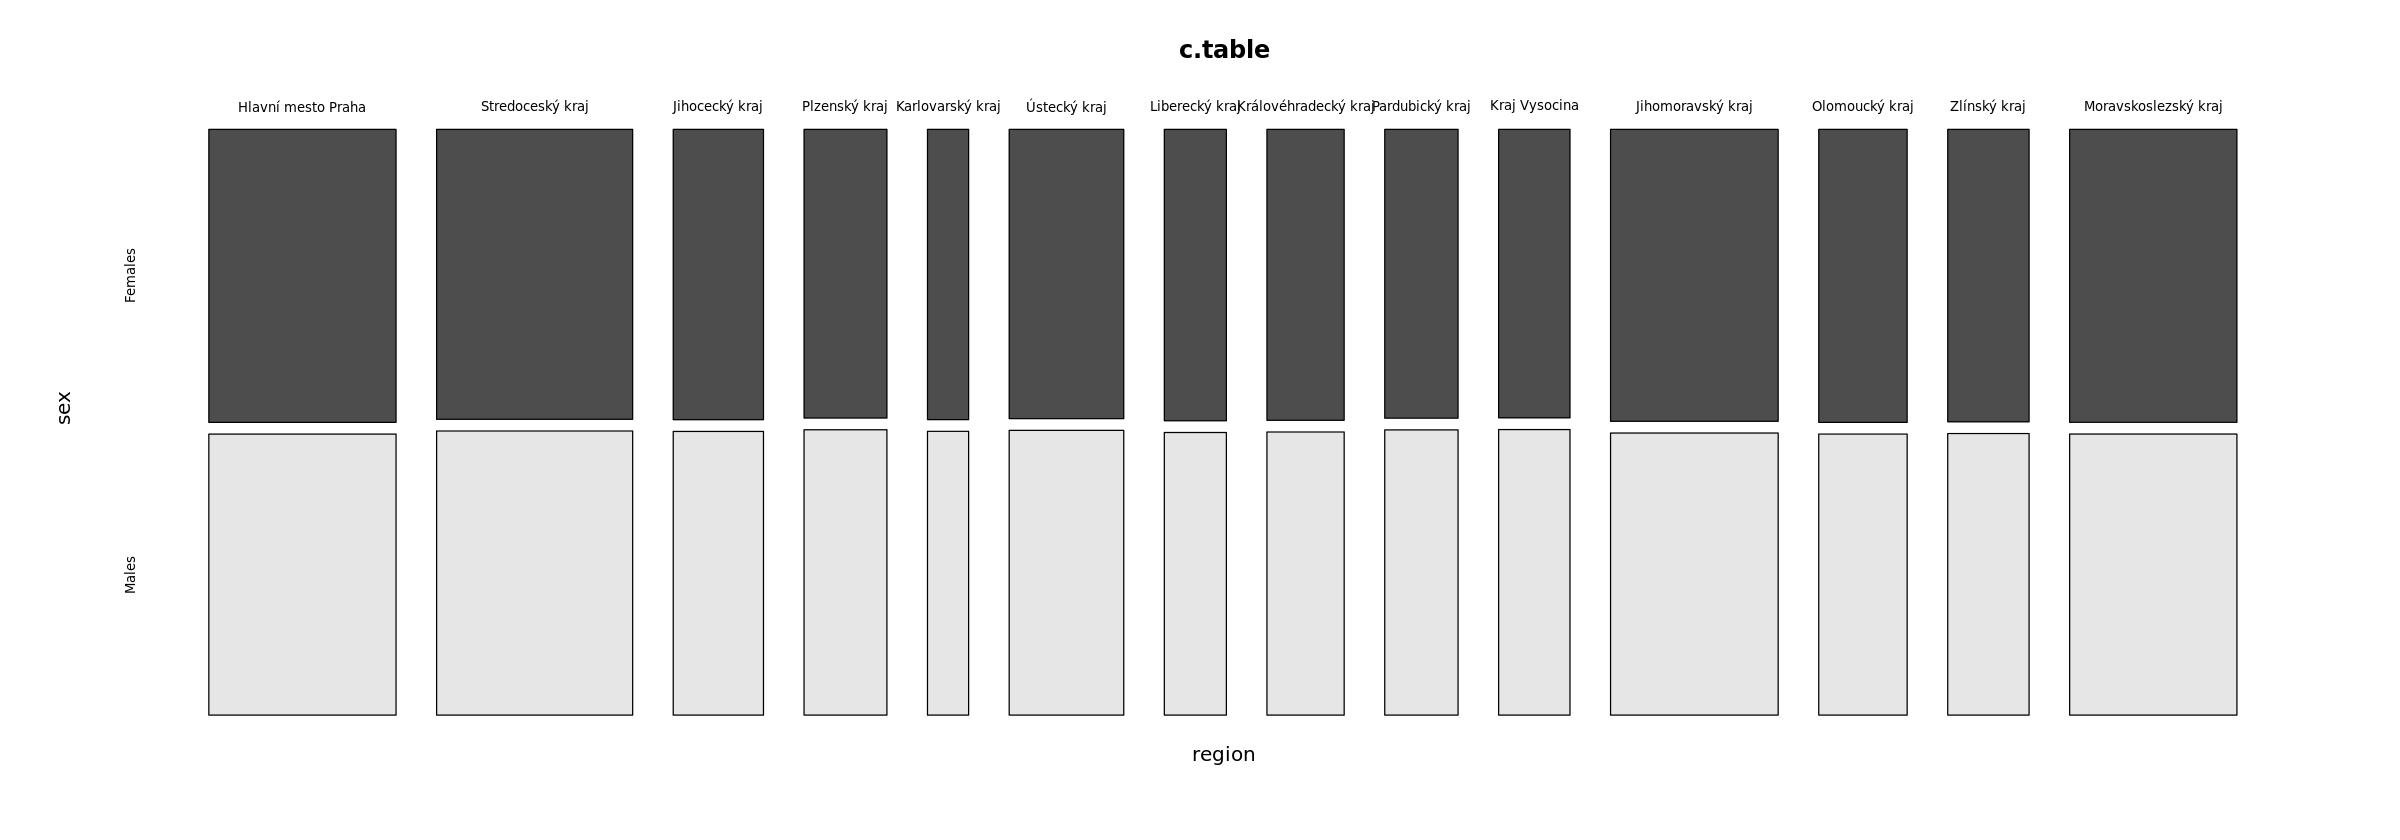

In [24]:
mosaicplot(c.table, color=T)

Pearsonův $\chi^2$ test nezávislosti zkoumá nezávislost pravděpodobnosti hodnot na řádkovém indexu, tedy hypotézu formalizujeme jako:
- $H_0$: řádkové pravděpodobnosti $p_{i1}, \ldots, p_{i\cdot}$ nezávisí na $i$
- $H_A$: neplatí $H_0$


In [25]:
pears <- chisq.test(c.table)
pears


	Pearson's Chi-squared test

data:  c.table
X-squared = 340.88, df = 13, p-value < 2.2e-16


Na základě výsledku tohoto testu *zamítáme* nulovou hypotézu, že by záznamy nebyly závislé na řádkovém indexu.

Na následujících kontingenčních tabulkách si můžeme prohlédnout kontrast předpokládaných hodnot podle Pearsonova $\chi^2$ testu nezávislosti a dat z eurostatu.

In [26]:
addmargins(pears$expected)

,Females,Males,Sum
Hlavní mesto Praha,676996.5,658087.5,1335084
Stredoceský kraj,708898.5,689098.5,1397997
Jihocecký kraj,326332.9,317218.1,643551
Plzenský kraj,299706.0,291335.0,591041
Karlovarský kraj,148732.6,144578.4,293311
Ústecký kraj,414287.7,402716.3,817004
Liberecký kraj,224371.4,218104.6,442476
Královéhradecký kraj,279302.1,271500.9,550803
Pardubický kraj,265130.6,257725.4,522856
Kraj Vysocina,258029.5,250822.5,508852


Na těchto datech jsme si všimli, že rozdíly mezi daty a předpokládanými hodnotami, pokud by řádky byly závislé, opravdu nejsou výrazné.

In [27]:
addmargins(pears$expected - pears$observed)

,Females,Males,Sum
Hlavní mesto Praha,-4433.4946,4.433495e+03,0.000000e+00
Stredoceský kraj,2887.5289,-2.887529e+03,0.000000e+00
Jihocecký kraj,829.8585,-8.298585e+02,0.000000e+00
Plzenský kraj,2483.0047,-2.483005e+03,0.000000e+00
Karlovarský kraj,434.6056,-4.346056e+02,0.000000e+00
Ústecký kraj,2560.6800,-2.560680e+03,0.000000e+00
Liberecký kraj,-257.5704,2.575704e+02,0.000000e+00
Královéhradecký kraj,179.0560,-1.790560e+02,0.000000e+00
Pardubický kraj,2063.6471,-2.063647e+03,2.910383e-11
Kraj Vysocina,2330.4766,-2.330477e+03,0.000000e+00


Další možností, jak u menších tabulek testovat nezávislost řádků je Fisherův exaktní test, který v našem případě opět *zamítá* hypotézu, že jsou řádky nezávislé.

In [28]:
fisher.test(c.table, simulate.p.value=T)


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  c.table
p-value = 0.0004998
alternative hypothesis: two.sided


Dalším ukazatelem nezávislosti řádků je Cramérovo delta, které v našem případě je velmi nízké a mluví ve prospěch naší domněnky, že jsou řádky závislé.

In [29]:
CramerV(c.table)

[1] 0.005643849